# Clustering
En este ejercicio se utilizará un dataset con los ingresos y educación de 32.000 personas alrededor del mundo. 
Entre los factores proveídos están la edad, educación, ocupación y su ingreso. 
El objetivo es clasificar de acuerdo a estos factores, y determinar los dos tipos de ingreso que existen, mayores de 50.000 y menores de 50.000. Este dato proviene del dataset, sin embargo para realizar el clustering se removerá dicho dato.


In [276]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import random
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder

In [277]:
data = pd.read_csv('income_evaluation.csv', sep=',')

In [278]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocesamiento
En esta sección, vamos a proceder a limpiar el dataset

In [279]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [280]:
data.shape

(32561, 15)

Se verifican los datos nulos

In [281]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Realizamos la conversión de datos categóricos a datos numéricos.


In [283]:
le = LabelEncoder()
data['income'] = le.fit_transform(data.income)
data['native-country'] = le.fit_transform(data['native-country'])
data['sex'] = le.fit_transform(data.sex)
data['race'] = le.fit_transform(data.race)
data['relationship'] = le.fit_transform(data.relationship)
data['occupation'] = le.fit_transform(data.occupation)
data['marital-status'] = le.fit_transform(data['marital-status'])
data['education'] = le.fit_transform(data.education)
data['workclass'] = le.fit_transform(data.workclass)


data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


Como se había dicho anteriormente, se remueve el dato que indica el ingreso. También se remueve el dato fnlwgt dado que no es relevante que tantas personas representan dicha fila.

In [383]:
y = data.occupation
x = data.drop(['income','fnlwgt'], axis=1)
#x = data.drop(['fnlwgt','occupation',  'marital-status', 'native-country','relationship','workclass', 'education', 'race', 'sex', 'income'], axis=1)
print(x.shape)
x.head()

(32561, 13)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,7,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,9,13,2,4,0,4,1,0,0,13,39
2,38,4,11,9,0,6,1,4,1,0,0,40,39
3,53,4,1,7,2,6,0,2,1,0,0,40,39
4,28,4,9,13,2,10,5,2,0,0,0,40,5


# Reducción  de dimensionalidad con PCA

### Primero escalamos el dataset

In [384]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
scaled_data=scaler.transform(x)

### Luego aplicamos PCA

Buscamos que tenga la cantidad mínima  de features, con un 95% de varianza.

In [385]:
from sklearn.decomposition import PCA
#pca=PCA(n_components=2)

pca=PCA(.95)
principalComponents = pca.fit(scaled_data)
pca_x = pca.transform(scaled_data)

In [386]:
print(x.shape)
x = pca_x
print(x.shape)

(32561, 13)
(32561, 12)


# DBSCAN
En esta sección se implementa el algoritmo de DBSCAN, el cual nos permitirá discernir entre el cluster y el ruido, según los parámetros que le demos.


In [387]:
def show_clusters(x, clusters):
    df = DataFrame(dict(x=x[:,0], y=x[:,1], label =clusters))
    cmap = plt.get_cmap('gnuplot')
    colors = {-1: 'red', 0:'blue', 1:'orange', 2:'green', 3:'skyblue',4: 'cyan', 5:'magenta', 6:'yellow', 7:'black'}
    #colors = [cmap(i) for i in np.linspace(0, 1, 5)]
    
    fig, ax = plt.subplots(figsize=(8,8))
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x',y='y', label=key, color=colors[key%8])

    plt.show()
    

Procederemos a realizar la búsqueda de los hiperparametros.

## Distancia máxima de 0.5

* Se seleccionó un eps de 0.5, lo que significa que tendría una distancia máxima de 0.5 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras minimas de 50

* Determinamos un min_samples de 50 para que el punto no sea considerado ruido. Dado que de esta manera podrá identificar todos las categorías.


Estimated number of clusters: 17
Estimated number of noise points: 27473
Silhouette Coefficient: -0.292


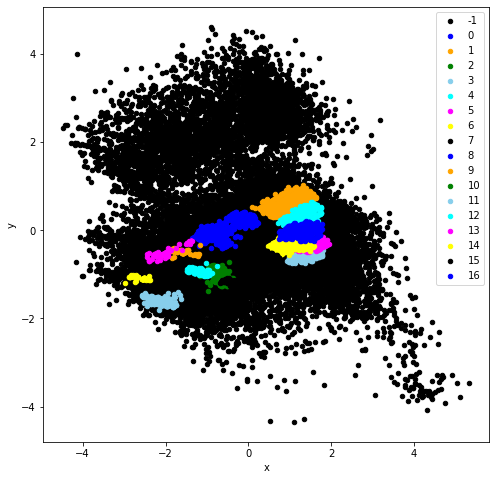

In [422]:
db = DBSCAN(eps=.5, min_samples=50).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

Como podemos observar la cantidad de muestras mínima de 50 es muy poca, razón por la que produce muchos clusters. Tambien podemos obeservar que mas de la mitad de los puntos del dataset equivalen a ruido(puntos negros). Lo cual podemos predecir que los datos están relativamente separados entre sí. 
De igual manera tenemos el coeficiente de silhouette, este es negativo, lo que indica que los puntos entre clusters están separados, y no existe mucha diferencia entre de distancia entre clusters.

## Distancia máxima de 0.5

* Se seleccionó un eps de 0.5, lo que significa que tendría una distancia máxima de 0.5 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 100

* Determinamos un min_samples de 100 para que el punto no sea considerado ruido. 

Estimated number of clusters: 5
Estimated number of noise points: 30329
Silhouette Coefficient: -0.311


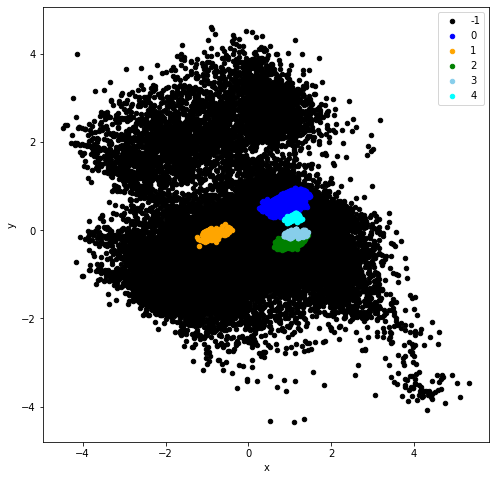

In [418]:
db = DBSCAN(eps=.5, min_samples=100).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

En esta sección podemos notar que la cantidad de clusters disminuyó, dado al aumento de min_samples. Sin embargo no significa que sea mejor que los datos anteriores. Existen 30329 puntos de 32561 datos que son considerados como ruido. Esto lo podemos observar en el gráfico desplegado. También vemos que el coeficiente de silhouette empeoró.


## Distancia máxima de 0.5

* Se seleccionó un eps de 0.5, lo que significa que tendría una distancia máxima de 0.5 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 150

* Determinamos un min_samples de 100 para que el punto no sea considerado ruido. 


Estimated number of clusters: 1
Estimated number of noise points: 31400
Silhouette Coefficient: -0.207


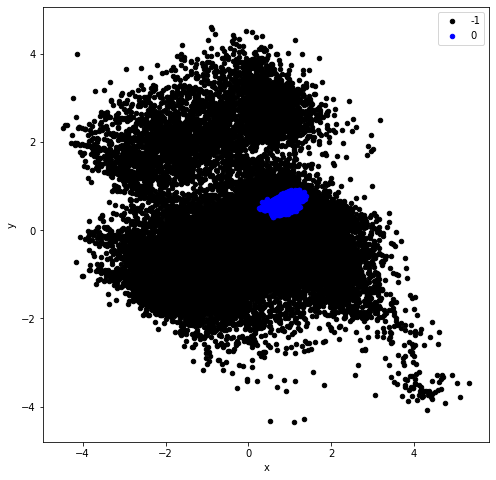

In [427]:
db = DBSCAN(eps=.5, min_samples=150).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

Ahora podemos ver que solo existe un cluster, lo cual es lo esperado al aumentar la cantidad de min_samples. Se ha vuelto aún menos representativo del dataset.

## Distancia máxima de 1

* Se seleccionó un eps de 1, lo que significa que tendría una distancia máxima de 1 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 50

* Determinamos un min_samples de 50 para que el punto no sea considerado ruido. 


Estimated number of clusters: 20
Estimated number of noise points: 16033
Silhouette Coefficient: -0.232


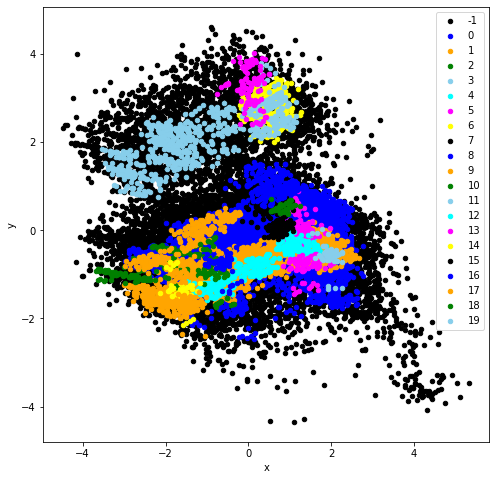

In [424]:
db = DBSCAN(eps=1, min_samples=50).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

En este DBSCAN podemos notar como la cantidad de clusters aumentó. Esto debido a un aumento en la distancia máxima entre muestras de un mismo clúster. Ahora existen menos datos tomados como ruido, sin embargo sigue siendo la mitad. 
Según el coeficiente de silhouette, no existe gran distinción entre cluster, ni tampoco clusters con cualidades marcadas.

## Distancia máxima de 1

* Se seleccionó un eps de 1, lo que significa que tendría una distancia máxima de 1 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 50

* Determinamos un min_samples de 50 para que el punto no sea considerado ruido. 


Estimated number of clusters: 9
Estimated number of noise points: 19700
Silhouette Coefficient: -0.166


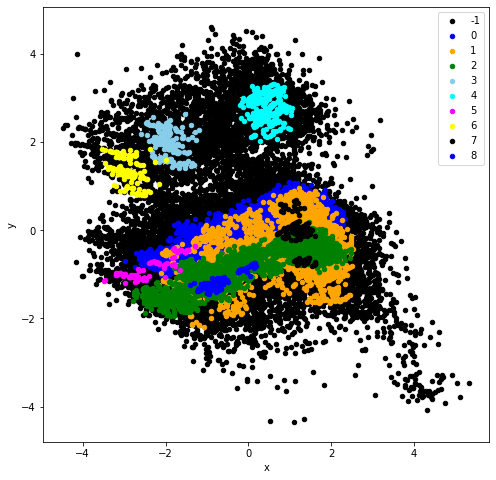

In [420]:
db = DBSCAN(eps=1, min_samples=100).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

La cantidad de clusters disminuyeron, sin embargo aún la cantidad de puntos como ruido siguen siendo muy alta, más de la mitad. Por otro lado, el coeficiente de silhouette mejoró ligeramente.

## Distancia máxima de 1

* Se seleccionó un eps de 1, lo que significa que tendría una distancia máxima de 1 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 150

* Determinamos un min_samples de 150 para que el punto no sea considerado ruido. 


Estimated number of clusters: 4
Estimated number of noise points: 22383
Silhouette Coefficient: -0.137


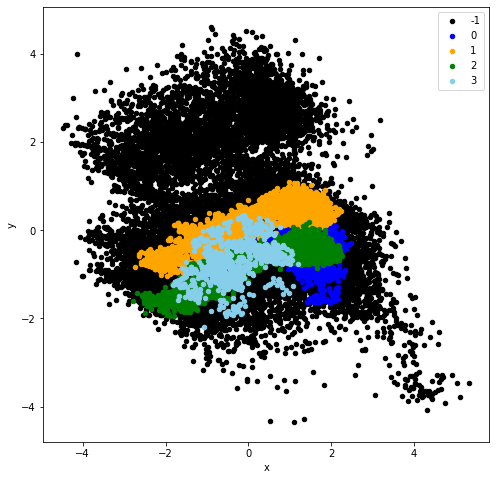

In [426]:
db = DBSCAN(eps=1, min_samples=150).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

La cantidad de clusters disminuyeron, sin embargo aún la cantidad de puntos como ruido siguen siendo muy alta, más de la mitad. Por otro lado, el coeficiente de silhouette volvio a mejorar ligeramente.

## Distancia máxima de 1.5

* Se seleccionó un eps de 1.5, lo que significa que tendría una distancia máxima de 1.5 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 50

* Determinamos un min_samples de 50 para que el punto no sea considerado ruido. 


Estimated number of clusters: 7
Estimated number of noise points: 7290
Silhouette Coefficient: 0.036


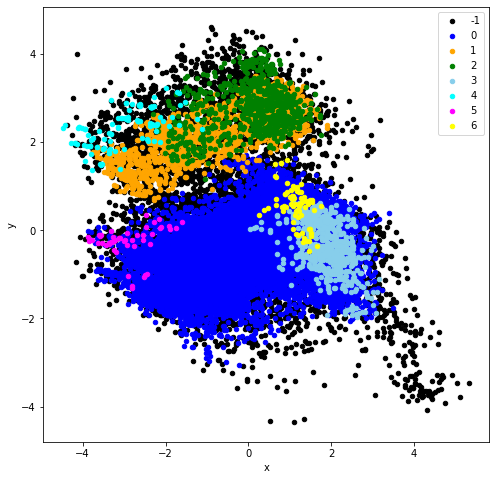

In [428]:
db = DBSCAN(eps=1.5, min_samples=50).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

En este caso tenemos un mejor DBSCAN dado que el coeficiente silhouette dio un mejor resultado. También podemos ver que los puntos de ruido disminuyeron. 
De manera gráfica observamos que existen clusters bien marcados entre los datos. 

## Distancia máxima de 1.5

* Se seleccionó un eps de 1.5, lo que significa que tendría una distancia máxima de 1.5 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 100

* Determinamos un min_samples de 100 para que el punto no sea considerado ruido. 


Estimated number of clusters: 5
Estimated number of noise points: 9526
Silhouette Coefficient: 0.054


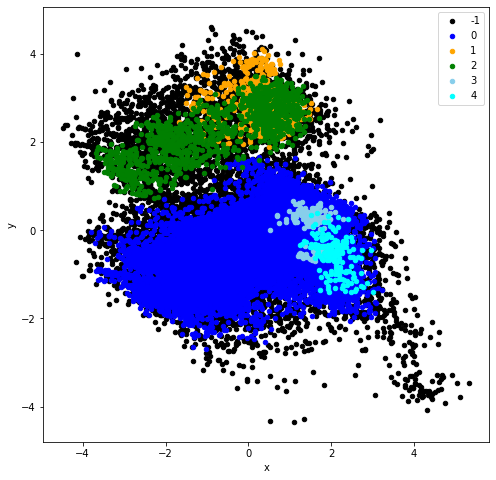

In [419]:
db = DBSCAN(eps=1.5, min_samples=100).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

Podemos notar que ahora existen menos clusters y mejor demarcados según el gráfico. También podemos ver que el coeficiente de silhouette mejoró ligeramente. 

## Distancia máxima de 1.5

* Se seleccionó un eps de 1.5, lo que significa que tendría una distancia máxima de 1.5 entre muestras. Esto determinará que pertenece y que no al vecindario o cluster.

## Muestras mínimas de 150

* Determinamos un min_samples de 150 para que el punto no sea considerado ruido. 


Estimated number of clusters: 4
Estimated number of noise points: 11323
Silhouette Coefficient: 0.009


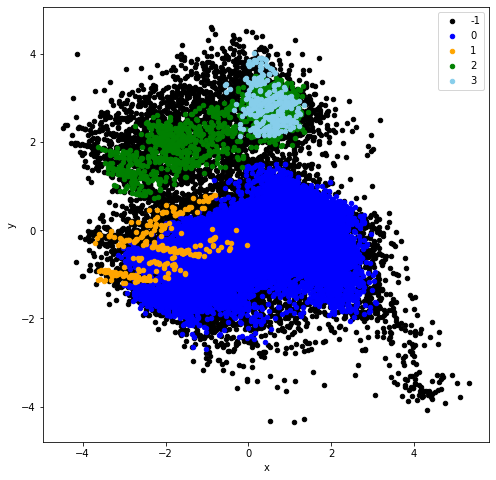

In [429]:
db = DBSCAN(eps=1.5, min_samples=150).fit(x)
clusters_n = db.labels_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x, labels))
show_clusters(x, clusters_n)

Podemos notar que ahora existen menos clusters y mejor demarcados según el gráfico. También podemos ver que el coeficiente de silhouette mejoró ligeramente 